# 1p Microendoscopic data analysis with CaImAn

1-photon microendoscopy is a type of microscopic imaging technique used primarily in biological research. This method involves the use of a miniaturized microscope, often in the form of an endoscope, which can be inserted into living tissues or organisms to observe cellular and subcellular structures in their natural environment.

The term "1-photon" refers to the fundamental process of light-matter interaction used in this type of microscopy. In 1-photon microscopy, a single photon of light is sufficient to excite the fluorescent dye or marker in the sample. This is in contrast to 2-photon microscopy, where two photons of lower energy are used to achieve the same level of excitation in the fluorescent dye.

Here are some key aspects of 1-photon microendoscopy:

1. Resolution and Depth: While it offers high-resolution imaging, the depth of penetration in 1-photon microendoscopy is less compared to 2-photon microscopy. This is because single-photon light scatters more in biological tissues.

2. Fluorescence Imaging: It relies on fluorescent markers that emit light when excited by photons. This fluorescence is then captured by the microscope to create an image of the sample.

3. Minimally Invasive: The endoscopic nature of the device makes it minimally invasive, allowing researchers to observe living tissues in real-time without significant disruption.

4. Applications: It's widely used in neuroscience, developmental biology, and other fields requiring live imaging at cellular and subcellular levels.

5. Technology: The technology involves sophisticated optics, including lenses and mirrors, to guide light to and from the sample, as well as sensitive detectors to capture the emitted fluorescence.

In [2]:
# Download data
from caiman.utils.utils import download_demo
fnames = ['data_endoscope.tif']
fnames = [download_demo(fnames[0], save_folder="1p")]

In [5]:
from caiman.source_extraction.cnmf import params as params


# dataset dependent parameters
frate = 10                       # movie frame rate
decay_time = 0.4                 # length of a typical transient in seconds

# motion correction parameters
motion_correct = True    # flag for performing motion correction
pw_rigid = False         # flag for performing piecewise-rigid motion correction (otherwise just rigid)
gSig_filt = (3, 3)       # size of high pass spatial filtering, used in 1p data
max_shifts = (5, 5)      # maximum allowed rigid shift
strides = (48, 48)       # start a new patch for pw-rigid motion correction every x pixels
overlaps = (24, 24)      # overlap between pathes (size of patch strides+overlaps)
max_deviation_rigid = 3  # maximum deviation allowed for patch with respect to rigid shifts
border_nan = 'copy'      # replicate values along the boundaries

mc_dict = {
    'fnames': fnames,
    'fr': frate,
    'decay_time': decay_time,
    'pw_rigid': pw_rigid,
    'max_shifts': max_shifts,
    'gSig_filt': gSig_filt,
    'strides': strides,
    'overlaps': overlaps,
    'max_deviation_rigid': max_deviation_rigid,
    'border_nan': border_nan
}

opts = params.CNMFParams(params_dict=mc_dict)
opts

CNMFParams:

data:

{'caiman_version': '1.9.8',
 'decay_time': 0.4,
 'dims': (128, 128),
 'dxy': (1, 1),
 'fnames': ['C:\\Users\\sange\\caiman_data\\example_movies\\1p\\data_endoscope.tif'],
 'fr': 10,
 'last_commit': 'FILE-1703154057',
 'mmap_C': None,
 'mmap_F': None,
 'var_name_hdf5': 'mov'}

spatial_params:

{'block_size_spat': 5000,
 'dist': 3,
 'expandCore': array([[0, 0, 1, 0, 0],
       [0, 1, 1, 1, 0],
       [1, 1, 1, 1, 1],
       [0, 1, 1, 1, 0],
       [0, 0, 1, 0, 0]]),
 'extract_cc': True,
 'maxthr': 0.1,
 'medw': None,
 'method_exp': 'dilate',
 'method_ls': 'lasso_lars',
 'n_pixels_per_process': None,
 'nb': 1,
 'normalize_yyt_one': True,
 'nrgthr': 0.9999,
 'num_blocks_per_run_spat': 20,
 'se': None,
 'ss': None,
 'thr_method': 'nrg',
 'update_background_components': True}

temporal_params:

{'ITER': 2,
 'bas_nonneg': False,
 'block_size_temp': 5000,
 'fudge_factor': 0.96,
 'lags': 5,
 'memory_efficient': False,
 'method_deconvolution': 'oasis',
 'nb': 1,
 'noise_metho

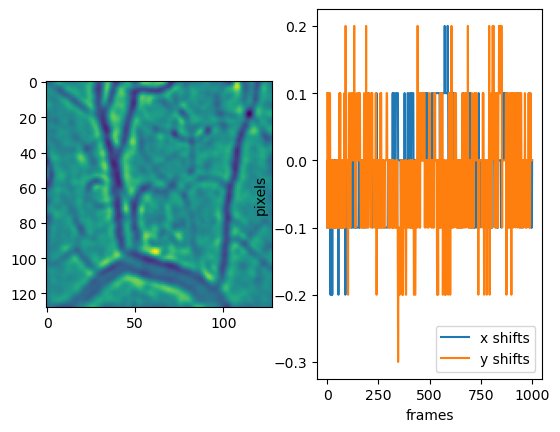

In [10]:
from caiman.motion_correction import MotionCorrect
import numpy as np
import caiman as cm
import matplotlib.pyplot as plt

if motion_correct:
    # do motion correction rigid
    mc = MotionCorrect(fnames, **opts.get_group('motion'))
    mc.motion_correct(save_movie=True)
    fname_mc = mc.fname_tot_els if pw_rigid else mc.fname_tot_rig
    if pw_rigid:
        bord_px = np.ceil(np.maximum(np.max(np.abs(mc.x_shifts_els)),
                                     np.max(np.abs(mc.y_shifts_els)))).astype(int)
    else:
        bord_px = np.ceil(np.max(np.abs(mc.shifts_rig))).astype(int)
        plt.subplot(1, 2, 1); plt.imshow(mc.total_template_rig)  # % plot template
        plt.subplot(1, 2, 2); plt.plot(mc.shifts_rig)  # % plot rigid shifts
        plt.legend(['x shifts', 'y shifts'])
        plt.xlabel('frames')
        plt.ylabel('pixels')

    bord_px = 0 if border_nan == 'copy' else bord_px
    fname_new = cm.save_memmap(fname_mc, base_name='memmap_', order='C',
                               border_to_0=bord_px)
else:  # if no motion correction just memory map the file
    fname_new = cm.save_memmap(fnames, base_name='memmap_',
                               order='C', border_to_0=0)